In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from helpers import *

Read Training Images
===

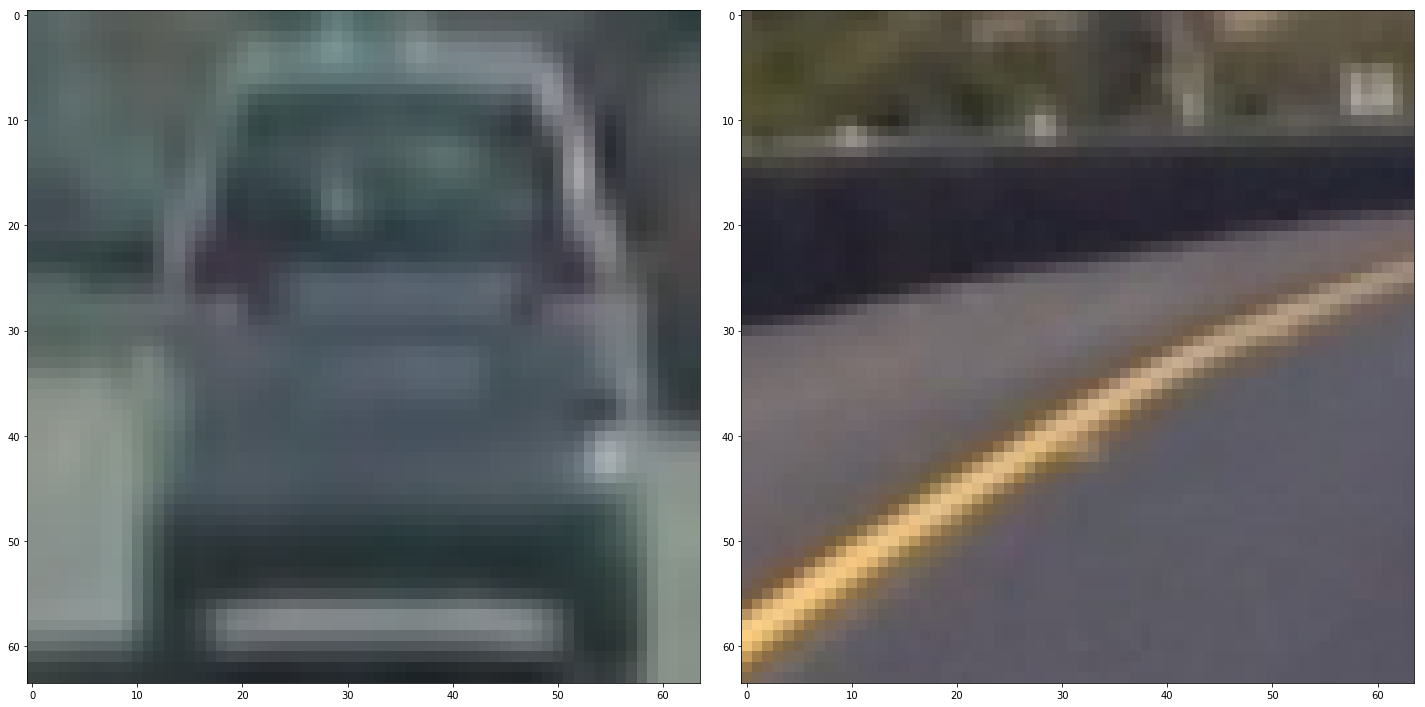

In [2]:
# Divide up into cars and notcars
v_images = glob.glob('vehicles/**/*.png', recursive=True)
nv_images = glob.glob('non-vehicles/**/*.png', recursive=True)
cars = []
notcars = []
for image in v_images:
    cars.append(image)
for image in nv_images:
    notcars.append(image)
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.tight_layout()
ax1.imshow(mpimg.imread(cars[5]))
ax2.imshow(mpimg.imread(notcars[5]))
fig.savefig('cars_notcars.jpg')

In [3]:
# Use a subset of the training data
#cars = shuffle(cars)[:2000]
#notcars = shuffle(notcars)[:2000]

In [4]:
# Manually split test and train data to avoid similar images between both sets
# Alternate between train and test sets for each batch of 10 images
cars_train = []
cars_intermediate = []

batch_size = 20
for i in range(0, len(cars), batch_size):
    for j in range(i, min(i+batch_size, len(cars))):
        if (int(i/batch_size)) % 2 == 0:
            cars_train.append(cars[j])
        else:
            cars_intermediate.append(cars[j])

# After shuffling take only 40% of the intermediate set as the test set and
# return the rest to the train set, so that the test set will be 20% of the total set
cars_intermediate = shuffle(cars_intermediate)
length = len(cars_intermediate)
cars_test = cars_intermediate[:int(0.4 * length)]
ret = cars_intermediate[int(0.4 * length):]
for i in ret:
    cars_train.append(i)

#Repeat for non car images.
notcars_train = []
notcars_intermediate = []

batch_size = 20
for i in range(0, len(cars), batch_size):
    for j in range(i, min(i+batch_size, len(cars))):
        if (int(i/batch_size)) % 2 == 0:
            notcars_train.append(notcars[j])
    else:
        notcars_intermediate.append(notcars[j])

notcars_intermediate = shuffle(notcars_intermediate)
length = len(notcars_intermediate)
notcars_test = notcars_intermediate[:int(0.4 * length)]
ret = notcars_intermediate[int(0.4 * length):]
for i in ret:
    notcars_train.append(i)

Extract HOG Features from the Training Data
===

In [7]:
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

t=time.time()

car_train_hog_features = extract_hog_features(cars_train, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_train_hog_features = extract_hog_features(notcars_train, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
car_test_hog_features = extract_hog_features(cars_test, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_test_hog_features = extract_hog_features(notcars_test, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

108.86 Seconds to extract HOG features...


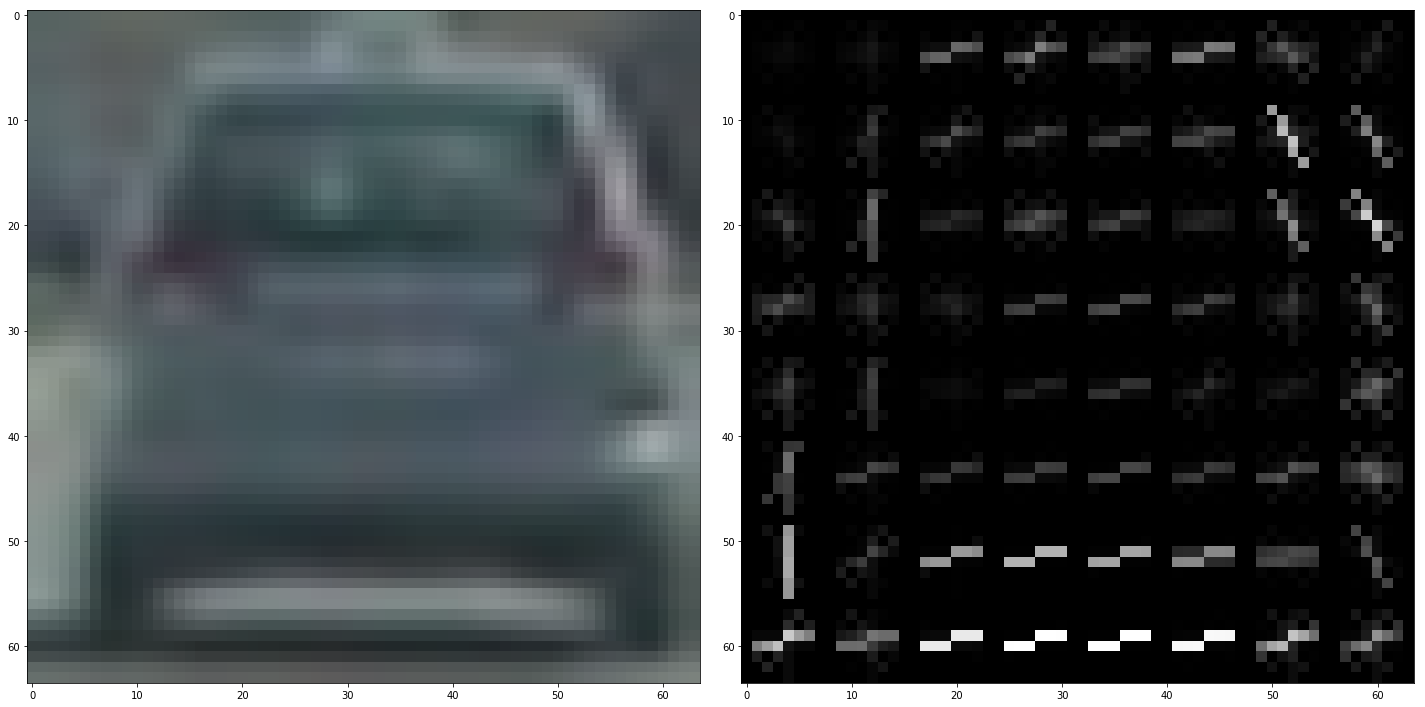

In [26]:
img = mpimg.imread(cars_train[3])
features, hog_image = get_hog(img[:,:,0], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.tight_layout()
ax1.imshow(img)
ax2.imshow(hog_image,cmap='gray')
fig.savefig('HOG.jpg')

Extract Color Features from the Training Data
===

In [27]:
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size = (16, 16)
hist_bins = 32
hist_range=(0, 256)

t=time.time()
car_train_color_features = extract_color_features(cars_train, cspace=colorspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, hist_range=hist_range)
notcar_train_color_features = extract_color_features(notcars_train, cspace=colorspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, hist_range=hist_range)
car_test_color_features = extract_color_features(cars_test, cspace=colorspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, hist_range=hist_range)
notcar_test_color_features = extract_color_features(notcars_test, cspace=colorspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, hist_range=hist_range)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract Color features...')

22.32 Seconds to extract Color features...


Combine both HOG and Color Features
===

In [28]:
car_train_features = np.hstack((car_train_hog_features, car_train_color_features))
notcar_train_features = np.hstack((notcar_train_hog_features, notcar_train_color_features))
car_test_features = np.hstack((car_test_hog_features, car_test_color_features))
notcar_test_features = np.hstack((notcar_test_hog_features, notcar_test_color_features))

#car_train_features = car_train_hog_features
#notcar_train_features = notcar_train_hog_features
#car_test_features = car_test_hog_features
#notcar_test_features = notcar_test_hog_features

Train Linear SVC Classifier
===

In [29]:
# Create an array stack of feature vectors
X_train = np.vstack((car_train_features, notcar_train_features)).astype(np.float64)
X_test = np.vstack((car_test_features, notcar_test_features)).astype(np.float64)

# Define the labels vector
y_train = np.hstack((np.ones(len(car_train_features)), np.zeros(len(notcar_train_features))))
y_test = np.hstack((np.ones(len(car_test_features)), np.zeros(len(notcar_test_features))))

# Shuffle training data
X_train, y_train  = shuffle(X_train, y_train)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC(C=0.0001)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 20
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6156
3.23 Seconds to train SVC...
Test Accuracy of SVC =  0.9819
My SVC predicts:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
For these 20 labels:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
0.00201 Seconds to predict 20 labels with SVC


Window Search
===

In [72]:
# Define a single function that can extract features using hog sub-sampling (combined with color features) and make predictions
def find_cars(img, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, bbox_list):
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    cimg_tosearch_hog = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    cimg_tosearch_color = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = cimg_tosearch_hog.shape
        cimg_tosearch_hog = cv2.resize(cimg_tosearch_hog, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        cimg_tosearch_color = cv2.resize(cimg_tosearch_color, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = cimg_tosearch_hog[:,:,0]
    ch2 = cimg_tosearch_hog[:,:,1]
    ch3 = cimg_tosearch_hog[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            # Extract the image patch
            #subimg_hog = cv2.resize(cimg_tosearch_hog[ytop:ytop+window, xleft:xleft+window], (window, window))
            subimg_color = cv2.resize(cimg_tosearch_color[ytop:ytop+window, xleft:xleft+window], (window, window))

            # Get color spatial features for the image patch
            spatial_features = bin_spatial(subimg_color, size=(16, 16))
            
            # Get color histogram features for the image patch
            hist_features = color_hist(subimg_color, nbins=32, bins_range=(0, 256))

            # Combine all features
            features = np.hstack((hog_features, spatial_features, hist_features))
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(features.reshape(1, -1))
            test_score = svc.decision_function(test_features)
            
            score_thresh = 0.8
            
            if test_score > score_thresh:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bbox_list.append(((xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart)))
    return draw_img, bbox_list

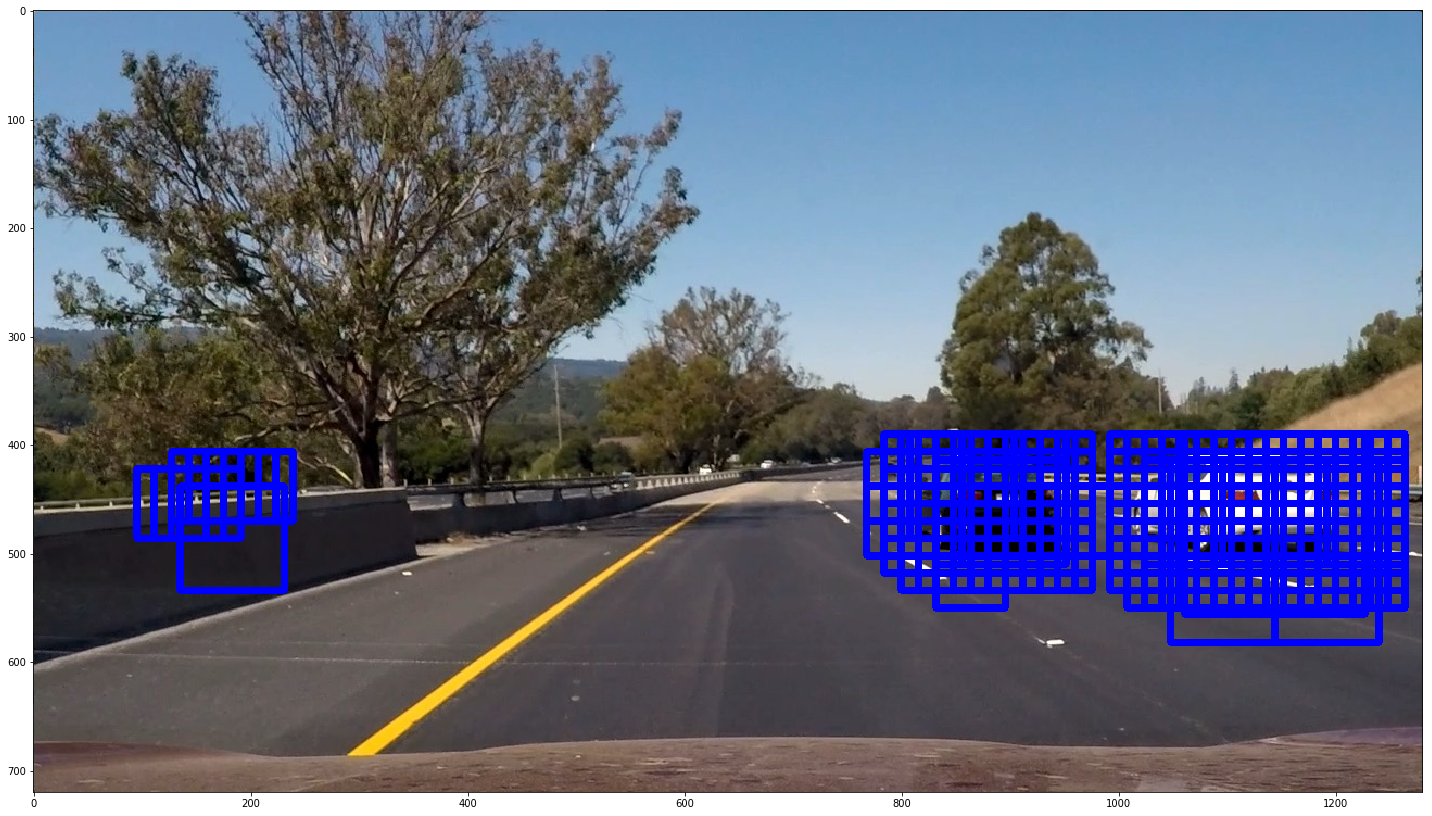

In [78]:
# Test find cars function
# Read test image
img = mpimg.imread('test_images/test6.jpg')
bbox_list = []

# Define search windows sizes and positions
# large windows
scale = 2.6
ystart = 390
ystop = 680
xstart = 20
xstop = 1270
out_img, bbox_list = find_cars(img, ystart, ystop, xstart, xstop, scale, svc, X_scaler,\
                                orient, pix_per_cell, cell_per_block, bbox_list)

# Medium windows
scale = 1.5
ystart = 390
ystop = 600
xstart = 15
xstop = 1270
out_img, bbox_list = find_cars(out_img, ystart, ystop, xstart, xstop, scale, svc, X_scaler,\
                                orient, pix_per_cell, cell_per_block, bbox_list)

# Small windows
scale = 1.0
ystart = 390
ystop = 550
xstart = 15
xstop = 1270
out_img, bbox_list = find_cars(out_img, ystart, ystop, xstart, xstop, scale, svc, X_scaler,\
                                orient, pix_per_cell, cell_per_block, bbox_list)

plt.figure(figsize=(20,12))
plt.imshow(out_img)
plt.tight_layout()
plt.savefig('search_windows.jpg')

Heat Maps
===

In [79]:
# Define a function to create heat maps from a list of bounding boxes
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [67]:
# Define a threshold function to ignore false positives
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [68]:
# Define a function to draw labeled boxes
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

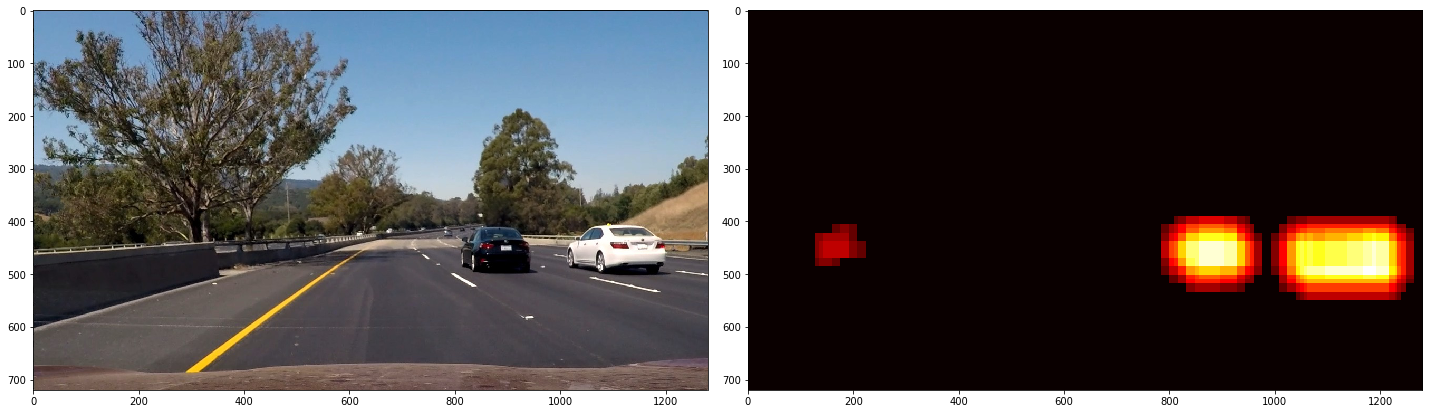

In [100]:
heat = np.zeros_like(img[:, :, 0]).astype(float)
heatmap = add_heat(heat, bbox_list)
heatmap = apply_threshold(heatmap, 2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
ax1.imshow(img)
ax2.imshow(heatmap, cmap='hot')
fig.tight_layout()
fig.savefig('heatmap.jpg')

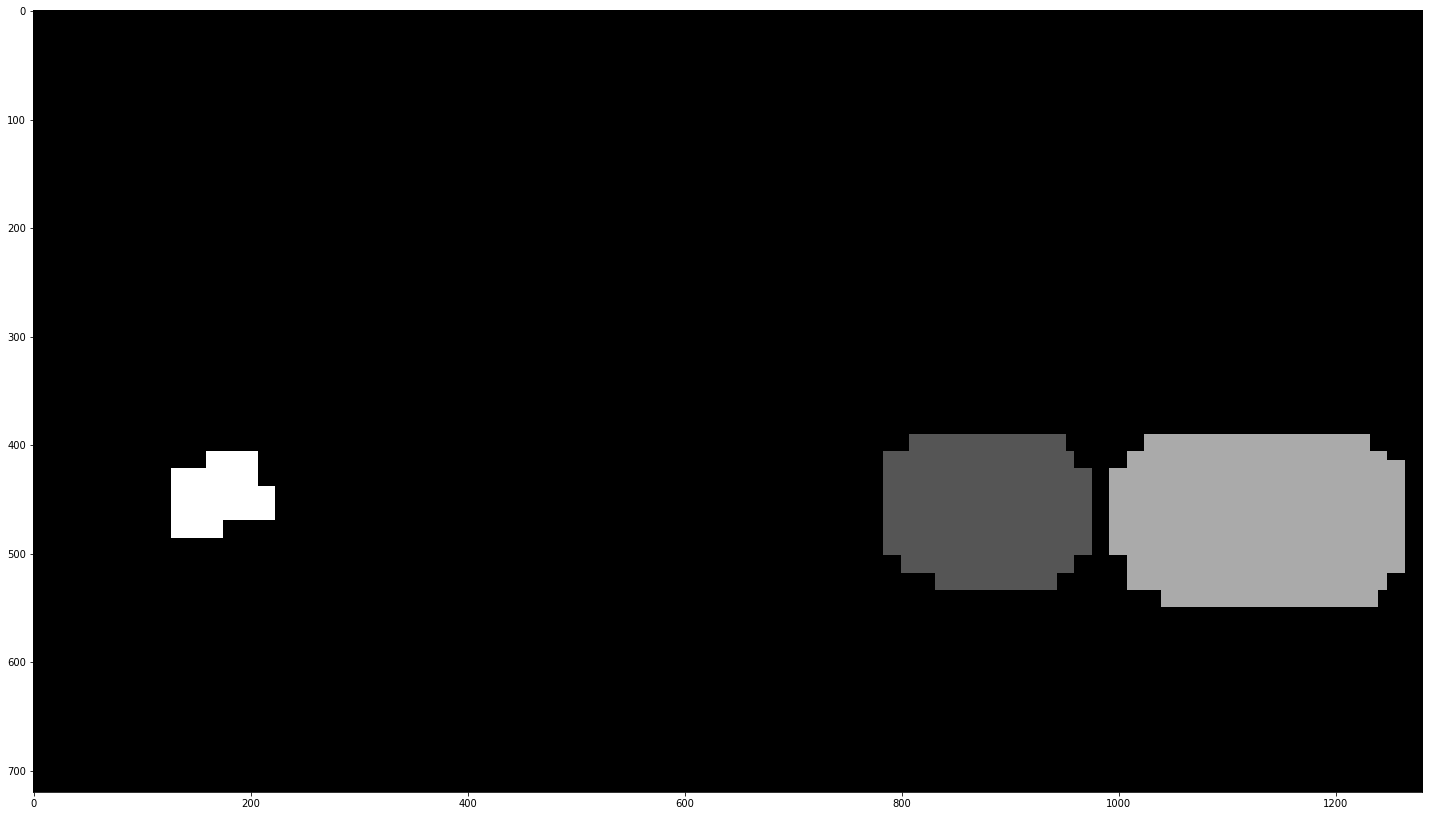

In [104]:
from scipy.ndimage.measurements import label

labels = label(heatmap)

plt.figure(figsize=(20,12))
plt.imshow(labels[0],cmap='gray')
plt.tight_layout()
plt.savefig('labels.jpg')

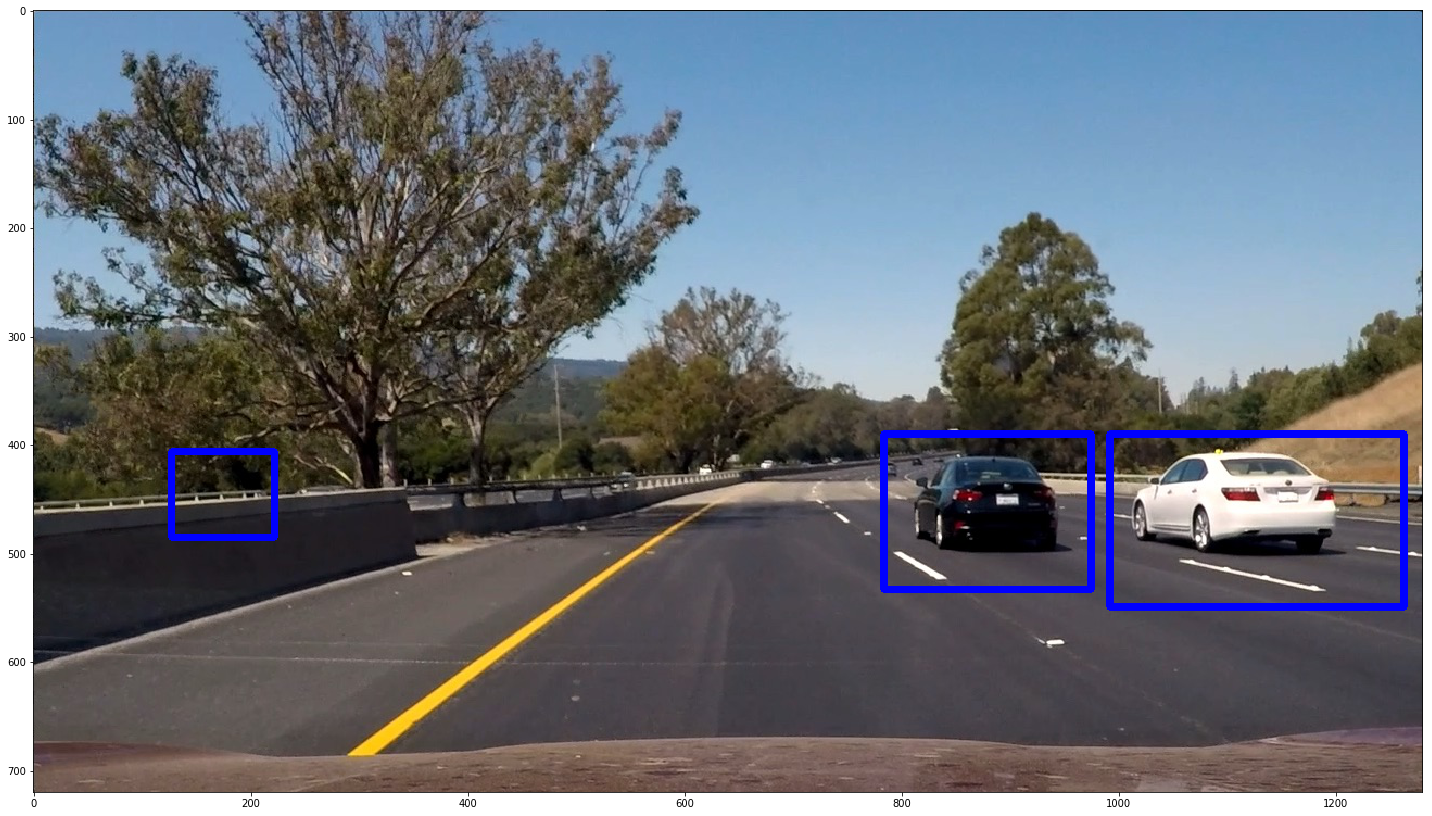

In [105]:
img = draw_labeled_bboxes(img, labels)

plt.figure(figsize=(20,12))
plt.imshow(img)
plt.tight_layout()
plt.savefig('bounding_boxes.jpg')

Pipeline
===

In [15]:
import collections
from scipy.ndimage.measurements import label

queue = collections.deque() # To hold bounding boxes across multiple frames

# define a pipeline to be fed video frames
def pipeline(img):
    bbox_list = []
    heat = np.zeros_like(img).astype(float)
    
    # Define search windows sizes and positions
    # large windows
    scale = 2.6
    ystart = 390
    ystop = 680
    xstart = 20
    xstop = 1270
    out_img, bbox_list = find_cars(img, ystart, ystop, xstart, xstop, scale, svc, X_scaler,\
                                    orient, pix_per_cell, cell_per_block, bbox_list)

    # Medium windows
    scale = 1.5
    ystart = 390
    ystop = 600
    xstart = 15
    xstop = 1270
    out_img, bbox_list = find_cars(out_img, ystart, ystop, xstart, xstop, scale, svc, X_scaler,\
                                    orient, pix_per_cell, cell_per_block, bbox_list)

    # Small windows
    scale = 1.0
    ystart = 390
    ystop = 550
    xstart = 15
    xstop = 1270
    out_img, bbox_list = find_cars(out_img, ystart, ystop, xstart, xstop, scale, svc, X_scaler,\
                                    orient, pix_per_cell, cell_per_block, bbox_list)
    
    qlen = len(queue)
    if qlen < 10:
        queue.append(bbox_list3)
    else:
        queue.append(bbox_list3)
        queue.popleft()
 
    for bboxes in queue:
        heatmap = add_heat(heat, bboxes)
    heatmap = np.uint8(np.clip(heatmap, 0, 255))
    thresh = apply_threshold(heatmap, 25)
    labels = label(thresh)
    return draw_labeled_bboxes(img, labels)
    #return out_img
    #return cv2.addWeighted(thresh, 0.5, out_img, 1, 0)

Test on Videos
===

In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
output = 'output.mp4'
raw_clip = VideoFileClip("project_video.mp4")
output_clip = raw_clip.fl_image(pipeline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


 83%|████████████████████████████████████████████████████████████████▋             | 1045/1261 [16:11<03:13,  1.12it/s]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [ ]:
# Define a function to extract some images from a video.
#def extract_frames(movie, times, imgdir):
#    clip = VideoFileClip(movie)
#    for t in times:
#        imgpath = os.path.join(imgdir, '{}.jpg'.format(t))
#        clip.save_frame(imgpath, t)

#movie = "project_video.mp4"
#imgdir = "difficult_images"
#times = np.linspace(20, 25, 51)


#extract_frames(movie, times, imgdir)